<a href="https://colab.research.google.com/github/ayoubbensakhria/finance_algo/blob/master/MA_and_Momentum_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Moving Average

Moving average is a series of averages points between many fixed subsets of a dataset. 

## Simple Moving Average
The unweighted mean of the previous k data-points.

\begin{aligned}
S M A_{k} &=\frac{p_{n-k+1}+p_{n-k+2} \cdots+p_{n}}{k} \\
&=\frac{1}{k} \sum_{i=n-k+1}^{n} p_{i}
\end{aligned}

## Cumulative Moving Average
The data arrive in an ordered datum stream, and the user would like to get the average of all of the data up until the current datum
\begin{aligned}
C M A_{n+1} &=\frac{x_{n+1}+n \cdot C M A_{n}}{n+1} \\
&=\frac{x_{n+1}+(n+1-1) \cdot C M A_{n}}{n+1} \\
&=\frac{(n+1) \cdot C M A_{n}+x_{n+1}-C M A_{n}}{n+1} \\
&=C M A_{n}+\frac{x_{n+1}-C M A_{n}}{n+1}
\end{aligned}

Where :
\begin{equation}
C M A_{n}=\frac{x_{1}+\cdots+x_{n}}{n}
\end{equation}

## Weighted Moving Average

The average that has multiplying factors to give different weights to data at different positions in the sample window. Mathematically, the weighted moving average is the convolution of the data with a fixed weighting function.

\begin{equation}
\mathrm{WMA}_{M}=\frac{n p_{M}+(n-1) p_{M-1}+\cdots+2 p_{((M-n)+2)}+p_{((M-n)+1)}}{n+(n-1)+\cdots+2+1}
\end{equation}

## Exponential Moving Average

The first-order infinite impulse response filter that applies weighting factors which decrease exponentially. The weighting for each older datum decreases exponentially, never reaching zero. The graph at right shows an example of the weight decrease.

$$
\mathrm{EMA}_{\text {today }}=\frac{p_{1}+(1-\alpha) p_{2}+(1-\alpha)^{2} p_{3}+(1-\alpha)^{3} p_{4}+\cdots}{1+(1-\alpha)+(1-\alpha)^{2}+(1-\alpha)^{3}+\cdots}
$$
since $1 / \alpha=1+(1-\alpha)+(1-\alpha)^{2}+\cdots$.

# Momentum
Momentum investing is a system of buying stocks or other securities that have had high returns over the past three to twelve months, and selling those that have had poor returns over the same period.

In [2]:
#backtrader
!pip install backtrader

     |████████████████████████████████| 410 kB 5.1 MB/s 


In [11]:
import math
from time import time
import pandas as pd
import numpy as np
import backtrader as bt
import matplotlib.pyplot as plt
from scipy.stats import linregress
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Vizualise the Stock Price Over Time

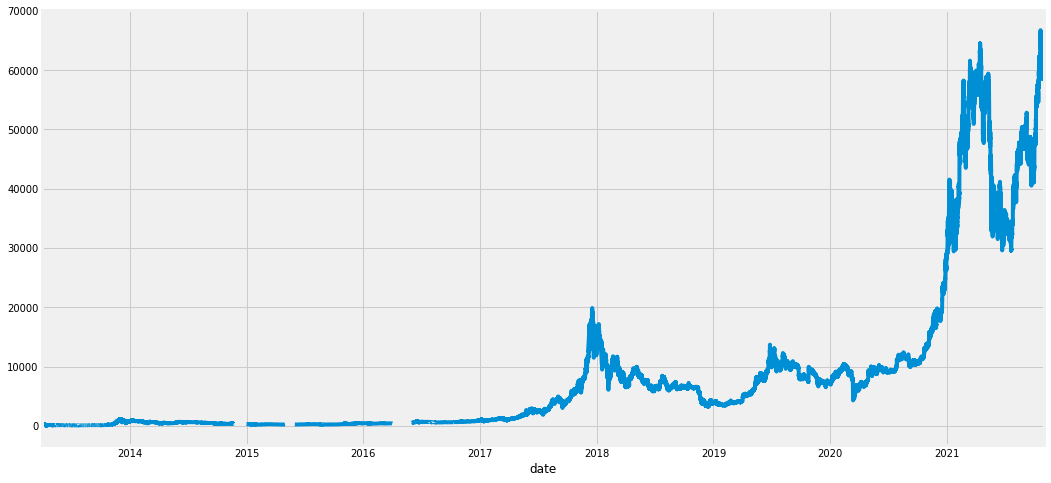

In [4]:
#read data
df = pd.read_csv('/content/drive/MyDrive/Yoctobe Fintech/Datasets/btcusd30mn.csv', parse_dates=True)
df.head()
# #setting index as date because some statsmodels might not work
df.rename(columns={'datetime': 'date'}, inplace=True)
df.index = df['date']
df.index = pd.to_datetime(df.index)
#plot
df['close'].plot(figsize=(16,8))

In [14]:
# resample df
ddf = df.resample("D").mean()
# using a range of 1 year of dates
mask = (ddf.index > '2020-01-01') & (ddf.index <= '2021-01-01')
ddf = ddf.loc[mask]

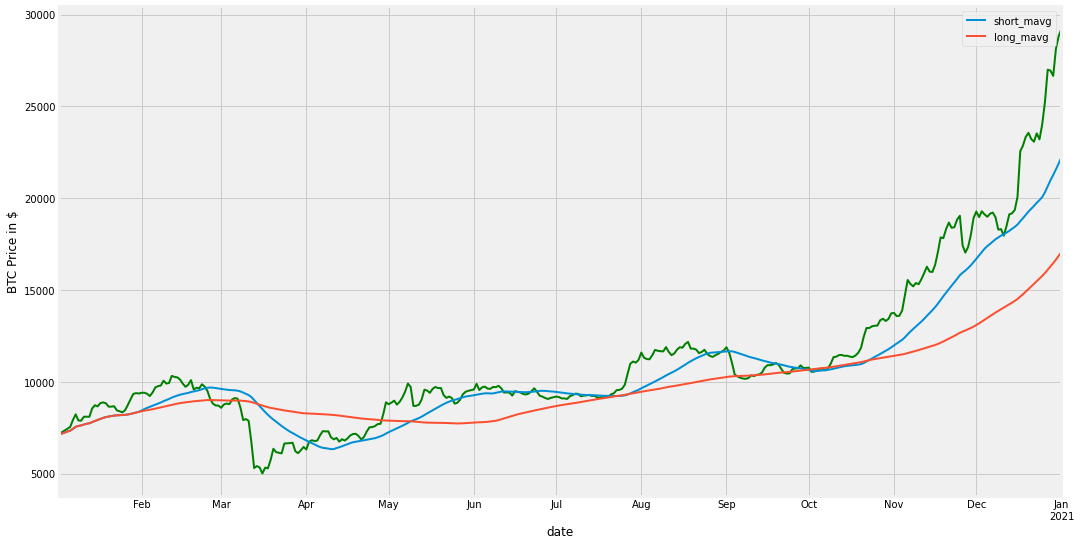

254


,signal,short_mavg,long_mavg,positions
date,,,,
2020-02-01,1.0,8444.331478,8401.449447,1.0
2020-02-02,1.0,8516.001931,8432.949668,0.0
2020-02-03,1.0,8582.580140,8460.889466,0.0
2020-02-04,1.0,8641.890628,8483.475229,0.0
2020-02-05,1.0,8704.344289,8510.232161,0.0


In [22]:
## Initialize the short and long windows
short_window = 30
long_window = 90

# Initialize signals
signals = pd.DataFrame(index=ddf.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = ddf['close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = ddf['close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   
# Generate trading orders
signals['positions'] = signals['signal'].diff()

## Initialize the plot figure
fig = plt.figure(figsize=(16,9))

## Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,ylabel='BTC Price in $')

## Plot the closing price
ddf['close'].plot(ax=ax1, color='g', lw=2.)

## Plot the short and long moving averages
signals[['short_mavg','long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()
print(len(signals.loc[signals.signal>0]))
signals.loc[signals.signal>0].head()


# Backtest

            BTC  holdings     cash    total  returns
date                                                
2020-01-02  0.0       0.0  10000.0  10000.0      NaN
2020-01-03  0.0       0.0  10000.0  10000.0      0.0
2020-01-04  0.0       0.0  10000.0  10000.0      0.0
2020-01-05  0.0       0.0  10000.0  10000.0      0.0
2020-01-06  0.0       0.0  10000.0  10000.0      0.0


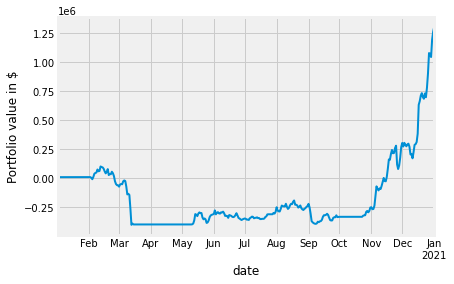

In [24]:
# Set the initial capital
initial_capital= float(10000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['BTC'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(ddf['close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(ddf['close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(ddf['close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio.head())

# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

In [ ]:
# Calculate the momentum
def calculate_momentum(data):
  log_data = np.log(data)
  # get the xs
  x_data = np.arange(len(log_date))
  beta, _, rvalue, _, _ = linregress(x_data, x_date)
  # annualize the slope
  return (1+beta)**252 * (rvalue **2)

In [ ]:
# Momentum class
class Momentum(bt.Indicator):
  lines = ('momentum_trend',)
  params = (('period', 90),)

  def __init__(self):
    self.addminperiod = self.params.period
  
  def next(self):
    returns = np.log(self.data.get(size=self.params.period))
    x = np.arange(len(returns))
    beta, _, rvalue, _, _ = linregress(x_data, x_date)
    # annualize the slope
    annualized = (1+beta)**252 
    # actual value of the momentum
    self.lines.momentum_trend[0] = annualized * rvalue**2


class MomentumStrategy(bt.Strategy):
  def __init__(self):
    self.counter = 0
    self.indicators = {}
    self.sorted_data = []
    self.btc = self.data[0] 
    self.sma200 = bt.indicators.MovingAverageSimple(self.btc, period = 200)
  
  def prenext(self):
    # count the # of days elapsed
    self.next()

  def next(self):
    # 1 week has passed
    if self.counter % 5 == 0:
      self.update_portfolio()
    if self.counter % 10 == 0:
      self.update_positions()

    self.counter += 1
  
  def rebalance_portfolio(self):
    self.sorted_data = list(filter(lambda stock_data: len(stock_data) > 100, self.stocks))
    # sort the BTCUSD based on momentum
    self.sorted_data.sort(key=lambda stock: self.indicators[stock]['momentum'][0])
    num_stocks = len(self.sorted_data)

    # sell stocks (close the long positions) - top 20%
    for index, single_stock in enumerate(self.sorted_data):
        # we can check whether are there open positions
        if self.getposition(self.data).size:
            # if the stock is not in the top 20% then close the long position
            # sell the stock if it's price falls below its 100 days MA
            if index > 0.2 * num_stocks or single_stock < self.indicators[single_stock]['sma100']:
                self.close(single_stock)

    # we open long positions when the SMA is below the SP500 index
    if self.spy < self.sma200:
        return

    # consider the top 20% of the stocks and buy accordingly
    for index, single_stock in enumerate(self.sorted_data[:int(0.2 * num_stocks)]):
        cash = self.broker.get_cash()
        value = self.broker.get_value()
        if cash > 0 and not self.getposition(self.data).size:
            size = value * 0.001 / self.indicators[single_stock]["atr20"]
            self.buy(single_stock, size=size)

    def update_positions(self):
        num_stocks = len(self.sorted_data)

        # top 20% momentum range
        for index, single_stock in enumerate(self.sorted_data[:int(0.2 * num_stocks)]):
            cash = self.broker.get_cash()
            value = self.broker.get_value()
            if cash > 0:
                size = value * 0.001 / self.indicators[single_stock]["atr20"]
                self.order_target_size(single_stock, size)


In [ ]:
stocks = []
cerebro = bt.Cerebro()
cerebro.adddata(bt.feeds.PandasData(dataname=df, plot=False))
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
# this is how we attach the strategy we have implemented
cerebro.addstrategy(MomentumStrategy)

cerebro.broker.set_cash(100000)
# commission fee is 1%
cerebro.broker.setcommission(0.01)

print('Initial capital: $%.2f' % cerebro.broker.getvalue())
results = cerebro.run()

print(f"Sharpe: {results[0].analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
print(f"Norm. Annual Return: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%")
print(f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")
print('Capital: $%.2f' % cerebro.broker.getvalue())

Initial capital: $100000.00


KeyboardInterrupt: ignored